In [1]:
from IPython.display import display, Math, Markdown
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy import ndimage
import scipy.optimize as opt
import sys

In [2]:
# (x,y) are 2D numpy arrays, specifying the Cartesian domain of the function
# (xc, yc) is the center of the laser pulse
# (ph_min, ph_max) are the min/max values of the wavefront phase
def spline_wfs(x, y, xc, yc, r_mid, r_max, ph_min, ph_max, r0):
    rsq = (x-xc)**2 + (y-yc)**2
    r = np.sqrt(rsq)
    ph_mid = ph_max * (1. - (r_mid/r0)**2)
    c0 = (ph_mid - ph_min) / (1. - r_mid/r_max)
    
    f_1 = ph_max * (1. - rsq/r0**2)
    f_2 = ph_min + c0 * (1. - r/r_max)
    return np.where(r<=r_mid, f_1, f_2)

def spline_wfs_fit(params, x, y, data, xc, yc, r_mid, r_max, ph_min):
    r0 = params[0]
    ph_max = params[1]
    g = spline_wfs(x, y, xc, yc, r_mid, r_max, ph_min, ph_max, r0)
    r = np.sqrt((x-xc)**2 + (y-yc)**2)
    weighted_diff = np.where(r<=r_mid, (g - data.reshape(g.shape))/r, 0.)
    return np.linalg.norm(weighted_diff)

In [3]:
# r_rms, the RMS radius of the 2D cylindrically symmetric gaussian, is the fitting parameter
# (x,y) are 2D numpy arrays, specifying the Cartesian domain of the function
# (xc, yc) is the center of the laser pulse
# (ph_min, ph_max) are the min/max values of the wavefront phase
def gaussian_ccd(x, y, xc, yc, n0_max, r_rms):
    return n0_max * np.exp(-(((x-xc)/r_rms)**2 + ((y-yc)/r_rms)**2))

# merit function used with scipy.optimize.minimize()
# diag_data is the 2D histogram from the experimental diagnostic
# r_rms, the RMS radius of the 2D cylindrically symmetric gaussian, is the fitting parameter
# args[0,1] = (x,y) are 2D numpy arrays, specifying the Cartesian domain of the function
# n0_max is the maximum value of the 2D histogram
# (xc, yc) is the center of the laser pulse
def gaussian_ccd_fit(params, x, y, xc, yc, data, r_mid):
    r_rms = params[0]
    n0_max = params[1]
    g = gaussian_ccd(x, y, xc, yc, n0_max, r_rms)
    rsq = (x-xc)**2 + (y-yc)**2
    r = np.sqrt(rsq)
    weighted_diff = np.where(r<r_mid, (g - data.reshape(g.shape))/r, 0.)
#    weighted_diff = np.where(r<r_mid, (g - data.reshape(g.shape)), 0.)
    return np.linalg.norm(weighted_diff)

In [4]:
# compute an azimuthally averaged radial profile
# Code adapted from https://github.com/vicbonj/radialprofile/blob/master/radialProfile.py

def azimuthalAverage(image, centerx, centery, type='mean'):
    '''
    Compute spherically symetric profiles around a center
    Returns
    -------
    profiles, errors, distance to the center in pixels
    '''

    y, x = np.indices(image.shape)
    r = np.hypot(x - centerx, y - centery)

    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    r_int = r_sorted.astype(int)

    deltar = r_int[1:] - r_int[:-1]
    rind = np.where(deltar)[0]
    rind2 = rind+1
    rind3 = np.zeros(len(rind2)+1)
    rind3[1:] = rind2
    rind3 = rind3.astype('int')

    if type == 'mean':
        aaa = [np.nanmean(i_sorted[rind3[i]:rind3[i+1]]) for i in range(len(rind3)-1)]
    elif type == 'median':
        aaa = [np.nanmedian(i_sorted[rind3[i]:rind3[i+1]]) for i in range(len(rind3)-1)]
    elif type == 'mode':
        aaa_list = [i_sorted[rind3[i]:rind3[i+1]] for i in range(len(rind3)-1)]
        aaa = []
        for part in aaa_list:
            if len(part) == 1:
                counts, xed = np.histogram(part, bins=len(part))
            elif (len(part) > 1) & (len(part) < 40):
                counts, xed = np.histogram(part, bins=int(len(part)/2))
            else:
                counts, xed = np.histogram(part, bins=20)
            if len(xed) != 2:
                aaa.append(0.5*(xed[1:]+xed[:-1])[np.where(counts == np.max(counts))[0]][0])
            elif len(xed) == 2:
                aaa.append(0.5*(xed[1:]+xed[:-1])[np.where(counts == np.max(counts))[0]][0])
    else:
        raise ValueError('Nope')
    aaa_std = [np.nanstd(i_sorted[rind3[i]:rind3[i+1]]) for i in range(len(rind3)-1)]
    dist_r = [np.mean(r_sorted[rind3[i]:rind3[i+1]]) for i in range(len(rind3)-1)]
    return np.array(aaa), np.array(aaa_std), np.array(dist_r)

In [5]:
# specify the path to the diagnostic data files
# dir_name = 'rslaser/package_data/'
dir_name = '../../../rslaser/package_data/'
ccd_name = 'IntensityImage_PumpOff.txt'
wfs_name = 'wfs_pump_off.txt'

# read the pixel size from the diagnostic metadata file
# with open("rslaser/package_data/camera_sensor_info.txt") as fh:
with open("../../../rslaser/package_data/camera_sensor_info.txt") as fh:
    for line in fh:
        if line.startswith("\"pixel_size_h_microns\""):
            pixel_size = float(line.split(":")[-1].split(",")[0])  # microns
display(Markdown(' pixel size is {} [$\mu m$] by {} [$\mu m$]'.format(pixel_size,pixel_size)))

 pixel size is 6.9 [$\mu m$] by 6.9 [$\mu m$]

In [6]:
# parse the wave front sensor (WFS) diagnostic data file
wfs_data = np.genfromtxt(dir_name+wfs_name, skip_header=1, skip_footer=0)

# convert from microns to radians
lambda0_micron = 0.8
rad_per_micron = math.pi / lambda0_micron
wfs_data *= rad_per_micron
# print(' ')
# print('rad_per_micron = ', rad_per_micron)

# clean up any NaN's
wfs_data[np.isnan(wfs_data)] = 777
wfs_data[np.where(wfs_data==777)] = np.min(wfs_data)
print(' ')
# print('np.shape(wfs_data) = ', np.shape(wfs_data))
print('wfs_data = ')
print(wfs_data)

x = np.linspace(0, wfs_data.shape[1] - 1, wfs_data.shape[1])
y = np.linspace(0, wfs_data.shape[0] - 1, wfs_data.shape[0])
x, y = np.meshgrid(x, y)
# print('x = ', x)
# print('y = ', y)

ph_min=np.min(wfs_data)
ph_max=np.max(wfs_data)
print(' ')
print('ph_min = ', ph_min)
print('ph_max = ', ph_max)

# find the center of mass
yc0, xc0 = ndimage.measurements.center_of_mass(wfs_data) 
print('xc0 ~ {0:4.1f}'.format(xc0))
print('yc0 ~ {0:4.1f}'.format(yc0))
# print('xc0 ~ {0:3.0f}  [microns]'.format(xc0*pixel_size))
# print('yc0 ~ {0:3.0f}  [microns]'.format(yc0*pixel_size))

 
wfs_data = 
[[-0.03163906 -0.08604975 -0.06766903 ... -0.00780944  0.05150183
   0.07471194]
 [-0.01798785 -0.07234341 -0.05743298 ... -0.01128394  0.01400257
   0.0535449 ]
 [ 0.00062387 -0.05292164 -0.04459367 ... -0.01204479  0.00652253
   0.03174102]
 ...
 [ 0.0163082   0.00158782 -0.0291936  ...  0.02224479 -0.00192909
   0.00715497]
 [ 0.02835983  0.02042711 -0.011783   ...  0.0004765  -0.01298996
   0.03570048]
 [-0.08604975  0.02668383  0.0185592  ... -0.00567007 -0.01840542
  -0.08604975]]
 
ph_min =  -0.08604974843169766
ph_max =  0.08604974843169766
xc0 ~ 58.9
yc0 ~  4.1


In [7]:
# r_max = math.sqrt(np.linalg.norm(x[-1,0] - xc0)*np.linalg.norm(x[0,-1] - yc0))
r_max = max(np.linalg.norm(x[-1,0] - xc0),np.linalg.norm(x[0,-1] - yc0))
print('r_max = ', r_max)
r0 = 0.2*r_max
x0=(r0, ph_max)

r_mid = 0.18*r_max
print('r_mid = ', r_mid)
print(' ')
args=(x, y, wfs_data.flatten(), xc0, yc0, r_mid, r_max, ph_min)

result = opt.minimize(spline_wfs_fit, x0, args, method='Nelder-Mead', options={'maxiter': 1e4, 'xatol': 0.0000001, 'fatol': 0.0000001})
print('result = ', result)

r_max =  58.89747046736724
r_mid =  10.601544684126104
 
result =   final_simplex: (array([[11.77949409,  0.08604975],
       [11.77949416,  0.08604975],
       [11.77949409,  0.08604975]]), array([0., 0., 0.]))
           fun: 0.0
       message: 'Optimization terminated successfully.'
          nfev: 95
           nit: 24
        status: 0
       success: True
             x: array([11.77949409,  0.08604975])


In [8]:
xc = xc0
yc = yc0
(r0, ph_max) = result.x
print('xc = ', xc)
print('yc = ', yc)
print('r0 = ', r0)
print('ph_min = ', ph_min)
print('ph_max = ', ph_max)

wfs_fit = spline_wfs(x, y, xc, yc, r_mid, r_max, ph_min, ph_max, r0)
print(' ')
print('wfs_fit = ', wfs_fit)

xc =  58.89747046736724
yc =  4.145827926653941
r0 =  11.77949409347345
ph_min =  -0.08604974843169766
ph_max =  0.08604974843169766
 
wfs_fit =  [[-0.08635874 -0.08424382 -0.08212908 ... -0.00842547 -0.00634396
  -0.00426622]
 [-0.08622775 -0.08411057 -0.08199351 ... -0.00807734 -0.00597965
  -0.0038842 ]
 [-0.0861326  -0.08401379 -0.08189502 ... -0.00782307 -0.00571341
  -0.00360481]
 ...
 [-0.09671326 -0.09476237 -0.09281671 ... -0.03140462 -0.03002138
  -0.0286764 ]
 [-0.09755158 -0.09561286 -0.09367969 ... -0.03300918 -0.03165743
  -0.03034427]
 [-0.09841754 -0.09649122 -0.09457079 ... -0.03463988 -0.03331869
  -0.03203633]]


In [9]:
profile, deviations, r = azimuthalAverage(wfs_data, xc0, yc0)
print(' ')
print(' r = ', r)
print(' profile = ', profile)

fit = np.zeros(profile.shape[0])

ph_mid = ph_max * (1. - (r_mid/r0)**2)
c0 = (ph_mid - ph_min) / (1. - r_mid/r_max)

f_1 = ph_max * (1. - np.power(r,2)/r0**2)
f_2 = ph_min + c0 * (1. - r/r_max)
fit = np.where(r<=r_mid, f_1, f_2)
print(' fit = ', fit)

 
 r =  [19.93197798 20.52671345 21.52436006 22.55094926 23.53899008 24.5384388
 25.55040304 26.52151864 27.4857634  28.51416615 29.54102527 30.54425067
 31.51805746 32.49495995 33.49936547 34.49512522 35.50454316 36.50209302
 37.49577603 38.49906985 39.50217595 40.51333969 41.51952042 42.51855049
 43.51627371 44.4959465  45.51983779 46.53834438 47.52659726 48.5361884
 49.54488747 50.55408899 51.54273231 52.5162261  53.54500941 54.57942017
 55.57070116 56.55296923 57.53272421 58.54023004 59.43043809 60.47569989
 61.46945702 62.42606016 63.4807374 ]
 profile =  [ 0.06100899  0.05433196  0.03299888  0.01883724  0.02424712  0.02544801
  0.02620913  0.02580847  0.02305962  0.0215035   0.0210607   0.0228524
  0.02100343  0.02408071  0.01928102  0.02228804  0.01992244  0.02194967
  0.01849056  0.01457351  0.01603098  0.01475819  0.01196241  0.01025683
  0.01333394  0.01420064  0.01109001  0.00693119  0.00041766 -0.00204954
 -0.0051387  -0.00643626 -0.00845722 -0.01216015 -0.01747735 -0.02287

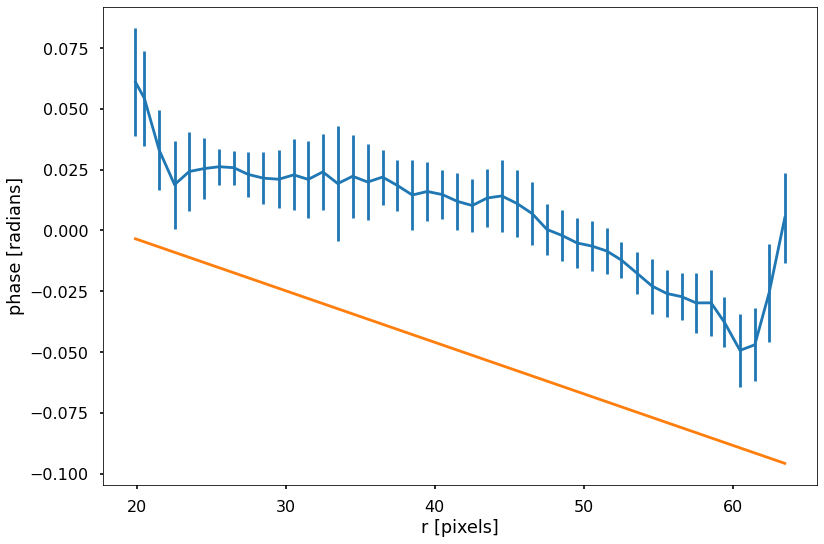

In [10]:
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    plt.errorbar(r, profile, yerr=deviations)    
    ax.plot(r, fit)
    ax.set_xlabel('r [pixels]')
    ax.set_ylabel('phase [radians]')

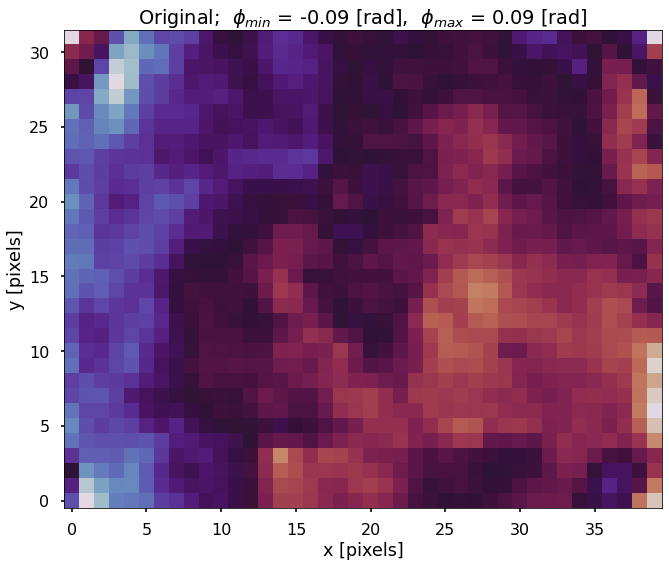

In [11]:
# plot the original data
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(wfs_data, cmap='twilight', vmin=ph_min, vmax=ph_max)
    ax.invert_yaxis()
    ax.set_xlabel('x [pixels]')
    ax.set_ylabel('y [pixels]')
    ax.set_title(r'Original;  $\phi_{{min}}$ ={0:6.2f} [rad]'.format(ph_min)+',  $\phi_{{max}}$ ={0:5.2f} [rad]'.format(ph_max))

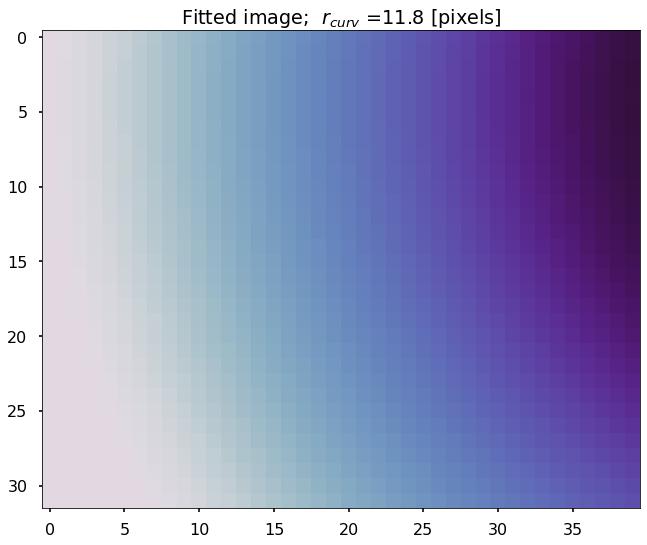

In [12]:
# plot the fitted image
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.invert_yaxis()
    ax.imshow(wfs_fit, cmap='twilight', vmin=ph_min, vmax=ph_max)
    ax.set_title(r'Fitted image;  $r_{{curv}}$ ={0:4.1f} [pixels]'.format(r0))

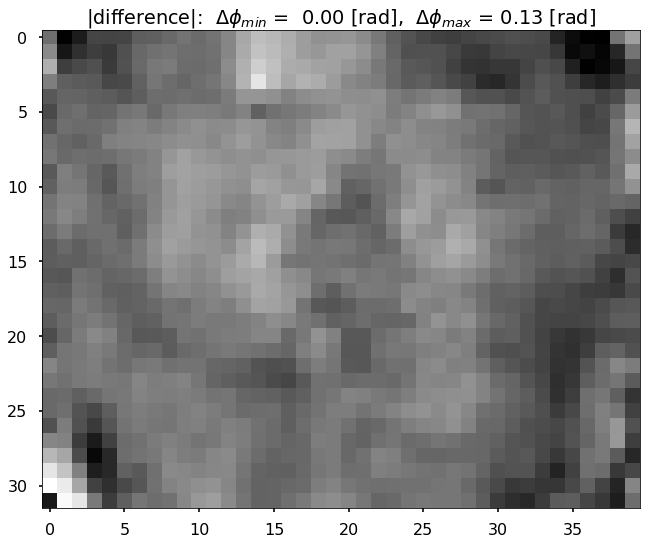

In [13]:
# plot the difference between the original and the Gaussian fit
 
wfs_diff = np.abs(wfs_data - wfs_fit)
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.invert_yaxis()
    ax.imshow(wfs_diff, cmap='gray', vmin=np.min(wfs_diff), vmax=np.max(wfs_diff))
    ax.set_title(r'|difference|:  $\Delta\phi_{{min}}$ ={0:6.2f} [rad]'.format(np.min(wfs_diff))+',  $\Delta\phi_{{max}}$ ={0:5.2f} [rad]'.format(np.max(wfs_diff)))

In [14]:
# calculate and print some absolute values for the photon counts

print(' ')
print('*************************')
# print('wfs_data = ')
# print(wfs_data)
min_data = np.min(wfs_data)
max_data = np.max(wfs_data)
print('min original = ', min_data)
print('max original = ', max_data)

print(' ')
print('*************************')
# print('wfs_fit = ')
# print(wfs_fit)
min_fit = np.min(wfs_fit)
max_fit = np.max(wfs_fit)
print('min fitted = ', min_fit)
print('max fitted = ', max_fit)

print(' ')
print('*************************')
# print('wfs_diff = ')
# print(wfs_diff)
min_diff = np.min(wfs_diff)
max_diff = np.max(wfs_diff)
print('min diff = ', min_diff)
print('max diff = ', max_diff)

 
*************************
min original =  -0.08604974843169766
max original =  0.08604974843169766
 
*************************
min fitted =  -0.09841754398279882
max fitted =  -0.0033613220234871427
 
*************************
min diff =  0.0006160335143269085
max diff =  0.12591141244787912


In [15]:
# Now let's fit a Gaussian to the intensity data from the CCD diagnostic file
# Use the (xc,yc) center location, determined from the WFS diagnostic file above
ccd_data = np.genfromtxt(dir_name+ccd_name, skip_header=1)

i_max = ccd_data.shape[1] - 1
j_max = ccd_data.shape[0] - 1

x = np.linspace(0, i_max+1, ccd_data.shape[1])
y = np.linspace(0, j_max+1, ccd_data.shape[0])
x, y = np.meshgrid(x, y)

n0_min=np.min(ccd_data)
n0_max=np.max(ccd_data)
n0_tot = np.sum(ccd_data)
print('n0_max = ', n0_max)
print('n0_tot = ', n0_tot)

n0_max =  52817.0
n0_tot =  27219346.0


In [16]:
# fit to a Gaussian
r_rms = 0.2*r_max
x0=(r_rms, n0_max)

r_mid = 0.4*r_max
args=(x, y, xc, yc, ccd_data.flatten(), r_mid)

result = opt.minimize(gaussian_ccd_fit, x0, args, method='Nelder-Mead', options={'maxiter': 1e4, 'xatol': 0.0000001, 'fatol': 0.0000001})
print('result = ', result)

result =   final_simplex: (array([[4.04087714e+08, 5.46490152e+03],
       [4.04087714e+08, 5.46490152e+03],
       [4.04087714e+08, 5.46490152e+03]]), array([1270.83244861, 1270.83244861, 1270.83244861]))
           fun: 1270.832448611037
       message: 'Optimization terminated successfully.'
          nfev: 578
           nit: 260
        status: 0
       success: True
             x: array([4.04087714e+08, 5.46490152e+03])


In [17]:
(r_rms, nfit_max) = result.x
w0 = r_rms * math.sqrt(2.) * pixel_size
x_rms = r_rms / math.sqrt(2.) * pixel_size
ccd_fit = gaussian_ccd(x, y, xc, yc, n0_max, r_rms).reshape(ccd_data.shape)

# compare the total photon count
nfit_tot = np.sum(ccd_fit)
rel_tot_dif = 100.*(1.-nfit_tot/n0_tot)
print('nfit_tot = {0:4.0f}'.format(nfit_tot))
print('relative difference of total counts = {0:3.1f}%'.format(rel_tot_dif))

# compare the center location with values calculated above
yc_ccd, xc_ccd = ndimage.measurements.center_of_mass(ccd_data) 
print('xc_ccd ~ {0:4.1f}'.format(xc_ccd) + ';  yc_ccd ~ {0:4.1f}'.format(yc_ccd))
print('xc_wfs ~ {0:4.1f}'.format(xc)     + ';  yc_wfs ~ {0:4.1f}'.format(yc))

nfit_tot = 67605760
relative difference of total counts = -148.4%
xc_ccd ~ 20.0;  yc_ccd ~ 14.4
xc_wfs ~ 58.9;  yc_wfs ~  4.1


In [18]:
profile, deviations, r = azimuthalAverage(ccd_data, xc, yc)
print(' ')
print(' r = ', r)
print(' profile = ', profile)

fit = np.zeros(profile.shape[0])
fit = nfit_max*np.exp(-(r/r_rms)**2)
print(' fit = ', fit)

 
 r =  [19.93197798 20.52671345 21.52436006 22.55094926 23.53899008 24.5384388
 25.55040304 26.52151864 27.4857634  28.51416615 29.54102527 30.54425067
 31.51805746 32.49495995 33.49936547 34.49512522 35.50454316 36.50209302
 37.49577603 38.49906985 39.50217595 40.51333969 41.51952042 42.51855049
 43.51627371 44.4959465  45.51983779 46.53834438 47.52659726 48.5361884
 49.54488747 50.55408899 51.54273231 52.5162261  53.54500941 54.57942017
 55.57070116 56.55296923 57.53272421 58.54023004 59.43043809 60.47569989
 61.46945702 62.42606016 63.4807374 ]
 profile =  [ 1683.25        2672.09090909  4612.          5845.52941176
  8049.83333333 10638.13636364 14264.31818182 16261.79166667
 18595.88       19057.67741935 21444.         20964.0625
 22373.59375    24742.91176471 23401.13157895 27360.88571429
 27467.86486486 31613.28571429 32378.02857143 31305.16666667
 33526.70588235 33315.61111111 32181.11764706 32281.91428571
 32003.75757576 30991.91176471 29063.30555556 28691.6969697
 27121.2058

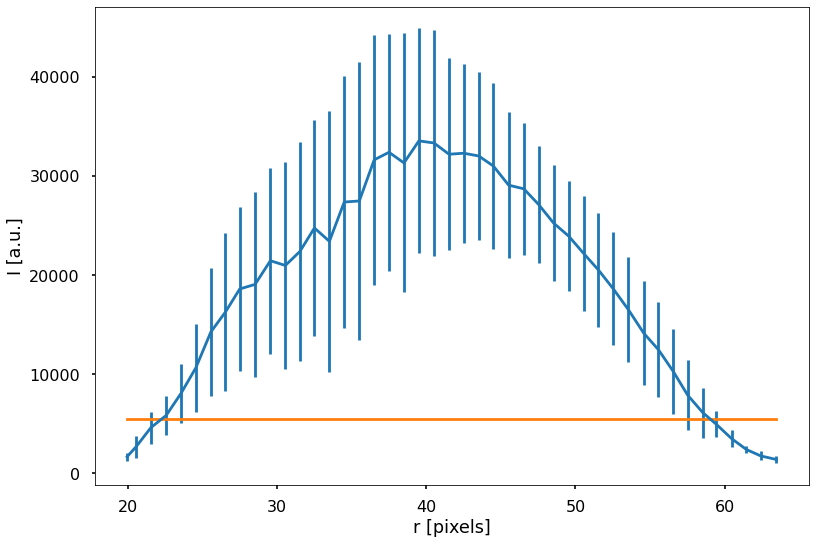

In [19]:
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    plt.errorbar(r, profile, yerr=deviations)    
    ax.plot(r, fit)
    ax.set_xlabel('r [pixels]')
    ax.set_ylabel('I [a.u.]')

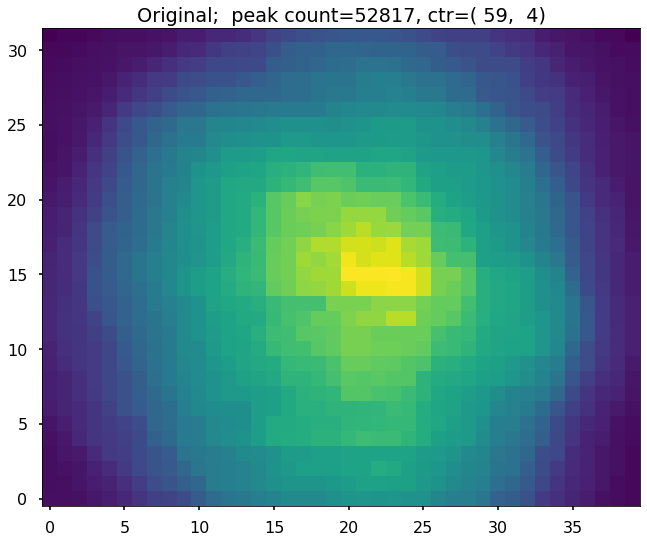

In [20]:
# plot the original image
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(ccd_data, cmap='viridis', vmin=0., vmax=n0_max)
    ax.invert_yaxis()
    ax.set_title('Original;  peak count={0:4.0f}'.format(n0_max)+', ctr=({0:3.0f},'.format(xc)+'{0:3.0f})'.format(yc))

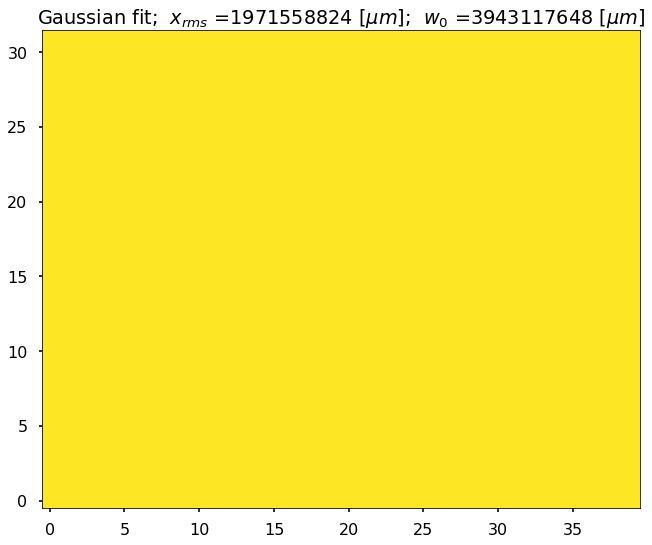

In [21]:
# plot the fitted Gaussian image
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(ccd_fit, cmap='viridis', vmin=0., vmax=n0_max)
    ax.invert_yaxis()
    ax.set_title(r'Gaussian fit;  $x_{{rms}}$ ={0:4.0f} [$\mu m$]'.format(x_rms) + ';  $w_0$ ={0:4.0f} [$\mu m$]'.format(w0))

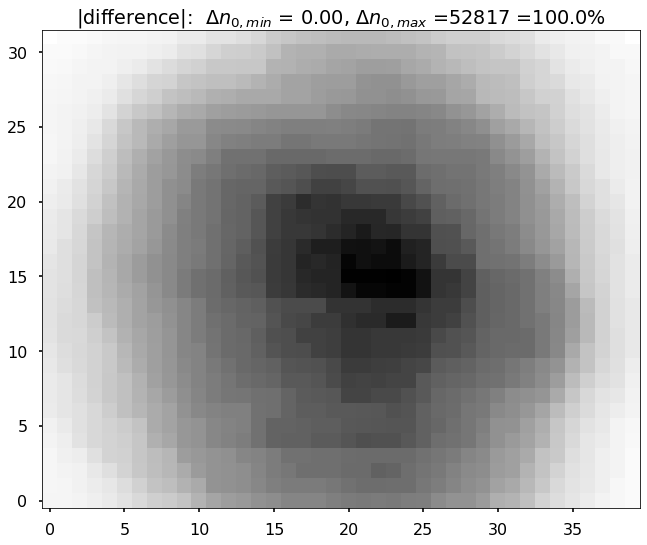

In [22]:
# plot the difference between the original and the Gaussian fit
 
ccd_diff = np.abs(ccd_data - ccd_fit)
with plt.style.context(('seaborn-poster')):
    fig = plt.figure()
    ax = fig.gca()
    ax.imshow(ccd_diff, cmap='gray', vmin=np.min(ccd_diff), vmax=np.max(ccd_diff))
    ax.invert_yaxis()
    ax.set_title(r'|difference|:  $\Delta n_{{0, min}}$ ={0:5.2f}'.format(np.min(ccd_diff))+r', $\Delta n_{{0, max}}$ ={0:5.0f}'.format(np.max(ccd_diff))+r' ={0:4.1f}%'.format(100.*(np.max(ccd_diff)/n0_max)))

In [23]:
# calculate and print some absolute values for the photon counts

print(' ')
print('*************************')
# print('ccd_data = ')
# print(ccd_data)
min_orig = np.min(ccd_data)
max_orig = np.max(ccd_data)
print('min original = ', min_orig)
print('max original = ', max_orig)

print(' ')
print('*************************')
# print('ccd_fit = ')
# print(ccd_fit)
min_fit = np.min(ccd_fit)
max_fit = np.max(ccd_fit)
print('min fitted = ', min_fit)
print('max fitted = ', max_fit)

print(' ')
print('*************************')
# print('ccd_diff = ')
# print(ccd_diff)
min_diff = np.min(ccd_diff)
max_diff = np.max(ccd_diff)
print('min diff = ', min_diff)
print('max diff = ', max_diff)

 
*************************
min original =  0.0
max original =  52817.0
 
*************************
min fitted =  52816.999999998625
max fitted =  52816.99999999988
 
*************************
min diff =  4.43833414465189e-10
max diff =  52816.999999999636
